In [ ]:
import sys

sys.path.append('../src')

from swfilter import SlicedWassersteinFilter, FastEuclidianFilter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.io import arff
import mlflow
import seaborn as sns


First, run this from terminal :

mlflow server --host 127.0.0.1 --port 8081

In [3]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# Create a new MLflow Experiment
experiment_id = "swfilter_exp_gridsearch_v2"
experiment = mlflow.set_experiment(experiment_id)

# Get Experiment Details
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Name: {}".format(experiment.name))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Experiment_id: 587539537557778910
Artifact Location: mlflow-artifacts:/587539537557778910
Name: swfilter_exp_gridsearch_v2
Tags: {}
Lifecycle_stage: active


In [4]:
dataset_list = [['Pima', 'Pima_withoutdupl_norm_35'],
                 ['Arrhythmia', 'Arrhythmia_withoutdupl_norm_46'],
                ['WPBC','WPBC_withoutdupl_norm'],
                ['Shuttle', 'Shuttle_withoutdupl_norm_v01'],
                ['Glass', 'Glass_withoutdupl_norm'],
                ['Ionosphere','Ionosphere_withoutdupl_norm'],
                ['Lymphography','Lymphography_withoutdupl_norm_idf'],
                #['Cardiotocography','Cardiotocography_withoutdupl_norm_22']
                ]

In [5]:
def import_dataset(folder_name:str, dataset_name:str)->pd.DataFrame:
    arff_file = arff.loadarff(f'../datasets/{folder_name}/{dataset_name}.arff')
    df_file = pd.DataFrame(arff_file[0])
    features = df_file.drop(columns=['outlier', 'id'])
    label = df_file['outlier']
    return features, label, df_file

def generate_data(folder_name:str, dataset_name:str, test_size:float=0.5, seed:int=42):
    features, label, df_file = import_dataset(folder_name, dataset_name)
    X = np.array(features.values)
    y = np.array(label.values == b'yes')
    y= np.where(y, -1, 1)

    if test_size == 1.0:
        X_test = X
        Y_test = y
        X_train = None 
        Y_train = None
    else:
        X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, y, test_size=test_size, random_state=seed)
    data = {'X_train':X_train, 'X_test':X_test, 'Y_train':Y_train, 'Y_test':Y_test, 'X':X, 'y':y}
    return data

    

## hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe, anneal, Trials, STATUS_OK,  pyll
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, make_scorer
from functools import partial
import mlflow


# Adjusting the objective functions to include cross-validation on training data and evaluation on testing data

def objective_lof(space, X_train, Y_train, X_test, Y_test, experiment_id, dataset_name):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        n_neighbors = int(space['n_neighbors'])
        algorithm = space['algorithm']
        leaf_size = int(space['leaf_size'])
        metric = space['metric']
        
        model = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            algorithm=algorithm,
            leaf_size=leaf_size,
            metric=metric,
            novelty=False
        )
        
        # Cross-validation on training data
        #cv_score = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring).mean()
    
        if X_train is not None:
            # Fit the model on the entire training dataset
            Y_pred = model.fit_predict(X_train)
            train_precision = sk.metrics.precision_score(Y_train, Y_pred, zero_division=0)
            train_accuracy = sk.metrics.accuracy_score(Y_train, Y_pred)
            mlflow.log_metric("train_precision", train_precision)
            mlflow.log_metric("train_accuracy", train_accuracy)

        
        # Evaluate on the testing data
        Y_pred = model.fit_predict(X_test)
        test_accuracy = sk.metrics.accuracy_score(Y_test, Y_pred)
        test_precision = sk.metrics.precision_score(Y_test, Y_pred, zero_division=0)
        test_recall_score = sk.metrics.recall_score(Y_test, Y_pred, zero_division=0)
        
        true_positive = np.sum((Y_test == -1) & (Y_pred == -1))
        false_positive = np.sum((Y_test == 1) & (Y_pred == -1))
        true_negative = np.sum((Y_test == 1) & (Y_pred == 1))
        false_negative = np.sum((Y_test == -1) & (Y_pred == 1))
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("true_negative", true_negative)
        mlflow.log_metric("false_negative", false_negative)
        
        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("n_neighbors", n_neighbors)
        mlflow.log_param("algorithm", algorithm)
        mlflow.log_param("leaf_size", leaf_size)
        mlflow.log_param("metric", metric)
        mlflow.log_param("dataset_name", dataset_name)
        
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall_score", test_recall_score)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.set_tag("model", "LocalOutlierFactor")
        
        if X_train is None:
            return {'loss': -test_precision, 'status': STATUS_OK}
        else:
            return {'loss': -train_precision, 'status': STATUS_OK}

def objective_forest(space, X_train, Y_train, X_test, Y_test, experiment_id, dataset_name):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        n_estimators = int(space['n_estimators'])
        max_samples = int(space['max_samples'])
        contamination = space['contamination']
        max_features = int(space['max_features'])
        
        model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            random_state=42
        )
        
        # Cross-validation on training data
        #cv_score = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring).mean()
        if X_train is not None:
            # Fit the model on the entire training dataset
            Y_pred = model.fit_predict(X_train)
            train_precision = sk.metrics.precision_score(Y_train, Y_pred, zero_division=0)
            train_accuracy = sk.metrics.accuracy_score(Y_train, Y_pred)
            mlflow.log_metric("train_precision", train_precision)
            mlflow.log_metric("train_accuracy", train_accuracy)

        
        # Evaluate on the testing data
        Y_pred = model.fit_predict(X_test)
        test_accuracy = sk.metrics.accuracy_score(Y_test, Y_pred)
        test_precision = sk.metrics.precision_score(Y_test, Y_pred, zero_division=0)
        test_recall_score = sk.metrics.recall_score(Y_test, Y_pred, zero_division=0)
        
        true_positive = np.sum((Y_test == -1) & (Y_pred == -1))
        false_positive = np.sum((Y_test == 1) & (Y_pred == -1))
        true_negative = np.sum((Y_test == 1) & (Y_pred == 1))
        false_negative = np.sum((Y_test == -1) & (Y_pred == 1))
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("true_negative", true_negative)
        mlflow.log_metric("false_negative", false_negative)
        
        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_samples", max_samples)
        mlflow.log_param("contamination", contamination)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("dataset_name", dataset_name)
       
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_recall_score", test_recall_score)
        mlflow.set_tag("model", "IsolationForest")
        
        if X_train is None:
            return {'loss': -test_precision, 'status': STATUS_OK}
        else:
            return {'loss': -train_precision, 'status': STATUS_OK}
    

def objective_sw(space, X_train, Y_train, X_test, Y_test, experiment_id, dataset_name):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        eps = float(space['eps'])
        n = int(space['n'])
        n_projections = int(space['n_projections'])
        p = float(space['p'])
        
        
        model = SlicedWassersteinFilter(
            eps=eps,
            n=n,
            n_projections=n_projections,
            p=p,
            seed=42,
            n_jobs=-1,
            swtype='original'  # Assuming a seed parameter is available for reproducibility
        )
        
        if X_train is not None:
            # Fit the model on the entire training dataset
            Y_pred, vote = model.fit_predict(X_train)
            train_accuracy = sk.metrics.accuracy_score(Y_train, Y_pred)
            train_precision = sk.metrics.precision_score(Y_train, Y_pred, zero_division=0)
            mlflow.log_metric("train_accuracy", train_accuracy)
            mlflow.log_metric("train_precision", train_precision)
        

        # Fit the model on the entire training dataset
        Y_pred, vote = model.fit_predict(X_test)
        test_precision = sk.metrics.precision_score(Y_test, Y_pred, zero_division=0)
        test_accuracy = sk.metrics.accuracy_score(Y_test, Y_pred)
        test_recall_score = sk.metrics.recall_score(Y_test, Y_pred, zero_division=0)
        
        true_positive = np.sum((Y_test == -1) & (Y_pred == -1))
        false_positive = np.sum((Y_test == 1) & (Y_pred == -1))
        true_negative = np.sum((Y_test == 1) & (Y_pred == 1))
        false_negative = np.sum((Y_test == -1) & (Y_pred == 1))
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("true_negative", true_negative)
        mlflow.log_metric("false_negative", false_negative)

        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("eps", eps)
        mlflow.log_param("n", n)
        mlflow.log_param("n_projections", n_projections)
        mlflow.log_param("p", p)
        mlflow.log_param("dataset_name", dataset_name)

        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_recall_score", test_recall_score)
        mlflow.set_tag("model", "SlicedWassersteinFilter")
        
        if X_train is None:
            return {'loss': -test_precision, 'status': STATUS_OK}
        else:
            return {'loss': -train_precision, 'status': STATUS_OK}
        
def objective_fast_euclidian(space, X_train, Y_train, X_test, Y_test, experiment_id, dataset_name):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        eps = float(space['eps'])
        n = int(space['n'])
        p = float(space['p'])
        
        
        model = FastEuclidianFilter(
            eps=eps,
            n=n,
            p=p,
            seed=42,
            n_jobs=-1,
        )
        
        if X_train is not None:
            # Fit the model on the entire training dataset
            Y_pred, vote = model.fit_predict(X_train)
            train_accuracy = sk.metrics.accuracy_score(Y_train, Y_pred)
            train_precision = sk.metrics.precision_score(Y_train, Y_pred, zero_division=0)
            mlflow.log_metric("train_accuracy", train_accuracy)
            mlflow.log_metric("train_precision", train_precision)
        

        # Fit the model on the entire training dataset
        Y_pred, vote = model.fit_predict(X_test)
        test_precision = sk.metrics.precision_score(Y_test, Y_pred, zero_division=0)
        test_accuracy = sk.metrics.accuracy_score(Y_test, Y_pred)
        test_recall_score = sk.metrics.recall_score(Y_test, Y_pred, zero_division=0)
        
        true_positive = np.sum((Y_test == -1) & (Y_pred == -1))
        false_positive = np.sum((Y_test == 1) & (Y_pred == -1))
        true_negative = np.sum((Y_test == 1) & (Y_pred == 1))
        false_negative = np.sum((Y_test == -1) & (Y_pred == 1))
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("true_negative", true_negative)
        mlflow.log_metric("false_negative", false_negative)

        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("eps", eps)
        mlflow.log_param("n", n)
        mlflow.log_param("p", p)
        mlflow.log_param("dataset_name", dataset_name)

        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_recall_score", test_recall_score)
        mlflow.set_tag("model", "FastSlicedWassersteinFilter")
        
        if X_train is None:
            return {'loss': -test_precision, 'status': STATUS_OK}
        else:
            return {'loss': -train_precision, 'status': STATUS_OK}
        


from hyperopt.base import miscs_update_idxs_vals
from hyperopt.pyll.base import dfs, as_apply
from hyperopt.pyll.stochastic import implicit_stochastic_symbols
# https://github.com/hyperopt/hyperopt/issues/200


class ExhaustiveSearchError(Exception):
    pass


def validate_space_exhaustive_search(space):
    supported_stochastic_symbols = ['randint', 'quniform', 'qloguniform', 'qnormal', 'qlognormal', 'categorical']
    for node in dfs(as_apply(space)):
        if node.name in implicit_stochastic_symbols:
            if node.name not in supported_stochastic_symbols:
                raise ExhaustiveSearchError('Exhaustive search is only possible with the following stochastic symbols: ' + ', '.join(supported_stochastic_symbols))


def suggest(new_ids, domain, trials, seed, nbMaxSucessiveFailures=1000):

    # Build a hash set for previous trials
    hashset = set([hash(frozenset([(key, value[0]) if len(value) > 0 else ((key, None))
                                   for key, value in trial['misc']['vals'].items()])) for trial in trials.trials])

    rng =  np.random.default_rng(seed)#np.random.RandomState(seed)
    rval = []
    for _, new_id in enumerate(new_ids):
        newSample = False
        nbSucessiveFailures = 0
        while not newSample:
            # -- sample new specs, idxs, vals
            idxs, vals = pyll.rec_eval(
                domain.s_idxs_vals,
                memo={
                    domain.s_new_ids: [new_id],
                    domain.s_rng: rng,
                })
            new_result = domain.new_result()
            new_misc = dict(tid=new_id, cmd=domain.cmd, workdir=domain.workdir)
            miscs_update_idxs_vals([new_misc], idxs, vals)

            # Compare with previous hashes
            h = hash(frozenset([(key, value[0]) if len(value) > 0 else (
                (key, None)) for key, value in vals.items()]))
            if h not in hashset:
                newSample = True
            else:
                # Duplicated sample, ignore
                nbSucessiveFailures += 1
            
            if nbSucessiveFailures > nbMaxSucessiveFailures:
                # No more samples to produce
                return []

        rval.extend(trials.new_trial_docs([new_id],
                                          [None], [new_result], [new_misc]))
    return rval

In [7]:
lof_bool = False
forest_bool = False
sw_bool = False
fast_sw_bool = True

#scoring = make_scorer(precision_score, zero_division=0)
max_evals = 300

In [9]:
for dataset in dataset_list:
    
    dataset_name = dataset[0]
    data = generate_data(dataset[0], dataset[1], test_size=1.0, seed=42)
    X_train = data['X_train']
    X_test = data['X_test']
    Y_train = data['Y_train']
    Y_test = data['Y_test']
    X = data['X']
    y = data['y']
    

    

    

    if lof_bool:
        # Define search spaces
        space_lof = {
            'n_neighbors': hp.quniform('n_neighbors', 10, 100,1),
            'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': hp.quniform('leaf_size', 5, 100, 1),
            'metric': hp.choice('metric', ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])
        }
        space_lof_discrete = {
            'n_neighbors': hp.choice('n_neighbors', [10, 25, 50, 75, 100, 500]),
            'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': hp.choice('leaf_size', [5, 10, 25, 50, 75, 100, 500]),
            'metric': hp.choice('metric', ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])
        }
        validate_space_exhaustive_search(space_lof)
        # Example of running a trial for LOF with the partial function
        objective_lof_partial = partial(objective_lof, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, experiment_id=experiment_id, dataset_name=dataset_name)

        trials_lof = Trials()
        best_lof = fmin(fn=objective_lof_partial,
                        space=space_lof_discrete,
                        algo=partial(suggest, nbMaxSucessiveFailures=1000),
                        max_evals=np.inf,
                        trials=trials_lof)

    if forest_bool:
        space_forest = {
        'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
        'max_samples': hp.quniform('max_samples', 1, X_test.shape[0],1),
        'contamination': hp.loguniform('contamination', -7, -0.7),
        'max_features': hp.quniform('max_features', 1, X_test.shape[1], 1)
         }
        
        space_forest_discrete = {
            'n_estimators': hp.choice('n_estimators',[ 10, 50, 100, 500]),
            'max_samples': hp.choice('max_samples', [1, int( X_test.shape[0]/4), int( X_test.shape[0]/2), int( 3*X_test.shape[0]/4), X_test.shape[0]]),
            'contamination': hp.choice('contamination', [0.01, 0.15, 0.3, 0.45]),
            'max_features': hp.choice('max_features', [1, int(X_test.shape[1]/2), X_test.shape[1]])

        }
        validate_space_exhaustive_search(space_forest_discrete)
        objective_forest_partial = partial(objective_forest, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, experiment_id=experiment_id, dataset_name=dataset_name)

        trials_iforest = Trials()
        best_iforest = fmin(fn=objective_forest_partial,
                            space=space_forest_discrete,
                            algo=partial(suggest, nbMaxSucessiveFailures=1000),
                            max_evals=np.inf,
                            trials=trials_iforest)

    if sw_bool:
        space_sw = {
        'eps': hp.loguniform('eps', -7, 4),
        'n': hp.quniform('n', 10, 100, 1),
        'n_projections': hp.quniform('n_projections', 50, 200, 1),
        'p': hp.uniform('p', 0.6, 1),

        }

        space_sw_discrete = {
            'eps': hp.choice('eps', [0.00001,  0.0001,  0.001,  0.01,  0.1 , 1, 10, 100, 1000]),
            'n': hp.choice('n', [25, 75]),
            'n_projections': hp.choice('n_projections', [100, 200]),
            'p': hp.choice('p', [0.5, 0.7, 0.9]),

        }
        print(validate_space_exhaustive_search(space_sw_discrete))
        objective_sw_partial = partial(objective_sw, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,  experiment_id=experiment_id, dataset_name=dataset_name)

        # Example of running a trial for SlicedWassersteinFilter with the partial function
        trials_sw = Trials()
        best_sw = fmin(fn=objective_sw_partial,
                    space=space_sw_discrete,
                    algo=partial(suggest, nbMaxSucessiveFailures=1000),
                    max_evals=np.inf,
                    trials=trials_sw)
        
    if fast_sw_bool:
        space_fast_sw = {
        'eps': hp.loguniform('eps', -7, 4),
        'n': hp.quniform('n', 10, 100, 1),
        'p': hp.uniform('p', 0.6, 1),

        }

        space_fast_sw_discrete = {
            'eps': hp.choice('eps', [0.00001,  0.0001,  0.001,  0.01,  0.1 , 1, 10, 100, 1000]),
            'n': hp.choice('n', [25, 75, 150, 200, 500]),
            'p': hp.choice('p', [0.5, 0.7, 0.9]),

        }
        print(validate_space_exhaustive_search(space_fast_sw_discrete))
        objective_fast_sw_partial = partial(objective_fast_euclidian, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,  experiment_id=experiment_id, dataset_name=dataset_name)

        # Example of running a trial for SlicedWassersteinFilter with the partial function
        trials_fast_sw = Trials()
        best_fast_sw = fmin(fn=objective_fast_sw_partial,
                    space=space_fast_sw_discrete,
                    algo=partial(suggest, nbMaxSucessiveFailures=1000),
                    max_evals=np.inf,
                    trials=trials_fast_sw)

None
135trial [00:31,  4.33trial/s, best loss: -0.6544021024967148]
None
135trial [00:49,  2.70trial/s, best loss: -0.5422222222222223]
None
135trial [00:27,  4.97trial/s, best loss: -0.875]             
None
135trial [00:33,  3.98trial/s, best loss: -1.0]              
None
135trial [00:27,  4.90trial/s, best loss: -1.0]             
None
135trial [00:30,  4.45trial/s, best loss: -1.0]              
None
135trial [00:28,  4.79trial/s, best loss: -1.0]               


## Extract results

In [10]:
df = mlflow.search_runs([experiment.experiment_id],filter_string="status = 'FINISHED'")
#building_ids = df['params.building_id']
display(df)
datasets = df['params.dataset_name'].unique()
print(datasets)
models = ['SlicedWassersteinFilter', 'FastSlicedWassersteinFilter', 'IsolationForest', 'LocalOutlierFactor']

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
0,256668e9a5d34e668612f8411c88038a,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/256668e9a...,2024-08-20 17:48:28.395000+00:00,2024-08-20 17:48:28.547000+00:00,0.040541,0.0,0.00,6.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,bright-flea-174
1,975d534ecadc4c5a891f48e6f52fcdb4,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/975d534ec...,2024-08-20 17:48:28.191000+00:00,2024-08-20 17:48:28.342000+00:00,0.959459,142.0,1.00,0.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,classy-goose-552
2,53452cf1bd794805b1ba9b38da3a846b,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/53452cf1b...,2024-08-20 17:48:27.988000+00:00,2024-08-20 17:48:28.140000+00:00,0.959459,142.0,1.00,0.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,upbeat-crane-989
3,c785b844f5254fceaaa5b838f6b813d5,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/c785b844f...,2024-08-20 17:48:27.785000+00:00,2024-08-20 17:48:27.937000+00:00,0.959459,142.0,1.00,0.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,adorable-zebra-247
4,3610513fe8d542c788eadd46602cb42e,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/3610513fe...,2024-08-20 17:48:27.583000+00:00,2024-08-20 17:48:27.734000+00:00,0.040541,0.0,0.00,6.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,hilarious-moth-557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8417,29f56d5a295b4a71b4f2f91f8c747499,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/29f56d5a2...,2024-08-05 13:25:09.735000+00:00,2024-08-05 13:25:56.330000+00:00,0.651042,500.0,1.00,0.0,...,None,None,None,None,200,SlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,suave-snipe-699
8418,10d33bb0a2e54e72b7e71b7b35fff72b,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/10d33bb0a...,2024-08-05 13:24:21.706000+00:00,2024-08-05 13:25:09.690000+00:00,0.348958,0.0,0.00,268.0,...,None,None,None,None,100,SlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,efficient-auk-193
8419,a4028ed311d646de8ef18dc948f6bb88,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/a4028ed31...,2024-08-05 13:24:05.305000+00:00,2024-08-05 13:24:21.660000+00:00,0.348958,0.0,0.00,268.0,...,None,None,None,None,100,SlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,bedecked-shrike-802
8420,28849a362ed948019c2f8c6c908ce41b,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/28849a362...,2024-08-05 13:21:42.538000+00:00,2024-08-05 13:24:05.259000+00:00,0.652344,470.0,0.94,31.0,...,None,None,None,None,200,SlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,caring-koi-652


['Lymphography' 'Ionosphere' 'Glass' 'Shuttle' 'WPBC' 'Arrhythmia' 'Pima']


In [11]:
import json
result_dict = {}

for dataset in datasets:
    for model in models:
        best_val= df.loc[(df['params.dataset_name'] == dataset) & (df['tags.model'] == model)].sort_values(by=['metrics.test_accuracy', 'end_time'], ascending=True).tail(1)

        #best_mse = df.loc[(df['params.benchmark_functions'] == function) & (df['tags.model_name'] == model)].sort_values(by='metrics.MSE_val', ascending=True).head(1)
        #best_build = df.loc[ (df['tags.model_name'] == model)].sort_values(by='metrics.MAE_VAL_all_buildings_scaled', ascending=True).head(1)

        if f'{dataset}' not in result_dict.keys():
            result_dict[f'{dataset}'] = {}

        display(best_val)
       
        result_dict[f'{dataset}'][f'{model}'] = {'test_accuracy': best_val['metrics.test_accuracy'].values[0], 'test_precision' : best_val['metrics.test_precision'].values[0]}



,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
7695,1e9f59d628624c798901b63bde6a7732,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/1e9f59d62...,2024-08-05 20:00:29.368000+00:00,2024-08-05 20:00:31.939000+00:00,0.993243,141.0,0.992958,6.0,...,None,None,None,None,200,SlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,legendary-rook-149


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
1,975d534ecadc4c5a891f48e6f52fcdb4,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/975d534ec...,2024-08-20 17:48:28.191000+00:00,2024-08-20 17:48:28.342000+00:00,0.959459,142.0,1.0,0.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,classy-goose-552


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
5862,019c11748b1b4bad8c1ab07d76ff99e6,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/019c11748...,2024-08-20 15:58:12.476000+00:00,2024-08-20 15:58:12.549000+00:00,0.972973,142.0,1.0,2.0,...,0.01,10,18,37,None,IsolationForest,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,monumental-goose-250


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
1170,73e322a5609f4bd592d271043a98c0bf,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/73e322a56...,2024-08-20 16:11:39.037000+00:00,2024-08-20 16:11:39.160000+00:00,0.993243,142.0,1.0,5.0,...,None,None,None,None,None,LocalOutlierFactor,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,adaptable-squid-371


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
7774,a43278aa25244f51a55cd968d4998024,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/a43278aa2...,2024-08-05 19:58:42.974000+00:00,2024-08-05 19:58:45.572000+00:00,0.641026,225.0,1.0,0.0,...,None,None,None,None,100,SlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,rogue-stork-395


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
193,cb1474a34ea64bdb944605ca3f189290,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/cb1474a34...,2024-08-20 17:47:47.114000+00:00,2024-08-20 17:47:47.284000+00:00,0.720798,141.0,0.626667,112.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,gregarious-ram-282


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
6150,1e385cb4c5644910889bfdabe8fe7e7b,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/1e385cb4c...,2024-08-20 15:57:16.687000+00:00,2024-08-20 15:57:16.751000+00:00,0.814815,203.0,0.902222,83.0,...,0.3,10,32,351,None,IsolationForest,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,sedate-toad-250


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
1865,839ab93569994d5eb83594929481f766,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/839ab9356...,2024-08-20 16:09:38.081000+00:00,2024-08-20 16:09:38.204000+00:00,0.880342,211.0,0.937778,98.0,...,None,None,None,None,None,LocalOutlierFactor,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,rare-sponge-183


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
7882,e4393a03e2b143b792ed83fb1422eca3,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/e4393a03e...,2024-08-05 19:42:17.077000+00:00,2024-08-05 19:42:19.616000+00:00,0.957944,205.0,1.0,0.0,...,None,None,None,None,100,SlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,enthused-elk-907


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
273,b938df1fdeb7403b81d9ce6976603c66,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/b938df1fd...,2024-08-20 17:47:29.243000+00:00,2024-08-20 17:47:29.393000+00:00,0.957944,205.0,1.0,0.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,gaudy-flea-157


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
6343,be0da34132834e75a7b6dc648ae43889,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/be0da3413...,2024-08-20 15:56:42.421000+00:00,2024-08-20 15:56:42.482000+00:00,0.957944,205.0,1.0,0.0,...,0.3,10,7,1,None,IsolationForest,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,agreeable-goat-924


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
2514,6b829c28a7bd495fb69f98fb20923e7c,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/6b829c28a...,2024-08-20 16:07:48.650000+00:00,2024-08-20 16:07:48.762000+00:00,0.957944,205.0,1.0,0.0,...,None,None,None,None,None,LocalOutlierFactor,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,polite-dolphin-155


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
7990,09bca64494cf483fb6b8a8a32df374e1,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/09bca6449...,2024-08-05 19:35:26.062000+00:00,2024-08-05 19:36:57.749000+00:00,0.987167,1000.0,1.0,0.0,...,None,None,None,None,200,SlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,painted-dolphin-385


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
406,b590c6dc7c874366b0d8fd9084477977,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/b590c6dc7...,2024-08-20 17:47:02.002000+00:00,2024-08-20 17:47:02.182000+00:00,0.987167,1000.0,1.0,0.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,kindly-grub-256


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
6598,8fbcbe64154249afa61046f69406c897,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/8fbcbe641...,2024-08-20 15:55:56.580000+00:00,2024-08-20 15:55:56.657000+00:00,0.987167,1000.0,1.0,0.0,...,0.3,50,1,1,None,IsolationForest,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,brawny-wren-189


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
3179,b47015e3ea5d4757aae97fd9c7f69a0a,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/b47015e3e...,2024-08-20 16:06:06.791000+00:00,2024-08-20 16:06:06.895000+00:00,0.962488,962.0,0.962,13.0,...,None,None,None,None,None,LocalOutlierFactor,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,charming-bat-121


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
8098,c00cc14781c4426d97996835874e613d,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/c00cc1478...,2024-08-05 15:58:33.551000+00:00,2024-08-05 15:58:34.333000+00:00,0.762626,151.0,1.0,0.0,...,None,None,None,None,100,SlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,bittersweet-worm-912


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
540,7a8bfc5a92f74a6b9b7ec963026c6311,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/7a8bfc5a9...,2024-08-20 17:46:28.379000+00:00,2024-08-20 17:46:28.529000+00:00,0.762626,151.0,1.0,0.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,spiffy-newt-138


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
6825,692deedecd4e412b94fe7e374c2b1990,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/692deedec...,2024-08-20 15:55:13.149000+00:00,2024-08-20 15:55:13.226000+00:00,0.762626,151.0,1.0,0.0,...,0.3,50,33,1,None,IsolationForest,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,efficient-croc-933


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
3858,cddab8b88ccb45aca2f819ba2401f82e,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/cddab8b88...,2024-08-20 16:04:19.778000+00:00,2024-08-20 16:04:19.872000+00:00,0.762626,151.0,1.0,0.0,...,None,None,None,None,None,LocalOutlierFactor,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,mysterious-colt-657


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
8264,a4a5e374a0ec4182ba444cefe699fd83,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/a4a5e374a...,2024-08-05 15:34:15.399000+00:00,2024-08-05 15:34:30.162000+00:00,0.671111,229.0,0.938525,73.0,...,None,None,None,None,200,SlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,righteous-dog-378


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
675,66a7a867fb4e4900b0a4ab5bcc4854ec,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/66a7a867f...,2024-08-20 17:46:01.027000+00:00,2024-08-20 17:46:01.334000+00:00,0.542222,244.0,1.0,0.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,agreeable-fish-896


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
7250,0e5ffff738974f6b972ab55d455c8f8a,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/0e5ffff73...,2024-08-20 15:53:59.289000+00:00,2024-08-20 15:53:59.579000+00:00,0.713333,181.0,0.741803,140.0,...,0.45,500,129,112,None,IsolationForest,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,merciful-skunk-15


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
4529,bf2e5900048d4642b39552037fef932d,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/bf2e59000...,2024-08-20 16:02:47.568000+00:00,2024-08-20 16:02:47.728000+00:00,0.651111,241.0,0.987705,52.0,...,None,None,None,None,None,LocalOutlierFactor,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,skittish-wren-748


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
8416,cf2a4f94ab364d7182f80a2bdfdb0674,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/cf2a4f94a...,2024-08-05 13:25:56.375000+00:00,2024-08-05 13:26:43.679000+00:00,0.66276,479.0,0.958,30.0,...,None,None,None,None,100,SlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,judicious-moth-672


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
823,6b743e5f30a84e70a2016c0400571751,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/6b743e5f3...,2024-08-20 17:45:08.161000+00:00,2024-08-20 17:45:08.337000+00:00,0.654948,499.0,0.998,4.0,...,None,None,None,None,None,FastSlicedWassersteinFilter,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,adventurous-lark-674


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
7380,1b807c92f640460492963a29fdb805a2,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/1b807c92f...,2024-08-20 15:53:35.892000+00:00,2024-08-20 15:53:35.992000+00:00,0.677083,452.0,0.904,68.0,...,0.15,100,4,192,None,IsolationForest,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,gaudy-skink-809


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.true_negative,metrics.test_recall_score,metrics.true_positive,...,params.contamination,params.n_estimators,params.max_features,params.max_samples,params.n_projections,tags.model,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
5243,d0844820e2324da8a71c9782100f8b22,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/d0844820e...,2024-08-20 16:00:58.909000+00:00,2024-08-20 16:00:58.989000+00:00,0.65625,470.0,0.94,34.0,...,None,None,None,None,None,LocalOutlierFactor,/home/julien/.local/lib/python3.10/site-packag...,julien,LOCAL,legendary-fowl-651


In [12]:
df_2 = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in result_dict.items()
    }, 
    axis=0)

In [17]:



data_precision = pd.DataFrame(columns=datasets, index=models)
data_accuracy = pd.DataFrame(columns=datasets, index=models)

for ids in datasets:
        for model in models:
                if ids in df_2['test_precision'] and model and ids is not None:
                        data_accuracy[ids][model] = df_2['test_accuracy'][ids][model]
                        data_precision[ids][model] = df_2['test_precision'][ids][model]
mapper = {'FastSlicedWassersteinFilter':'Fast Euclidian', 'SlicedWassersteinFilter':'Sliced Wasserstein', 'LocalOutlierFactor': 'Local Outlier Factor', 'IsolationForest':'Isolation Forest'}

data_accuracy.rename(mapper, axis=0, inplace=True)
data_precision.rename(mapper, axis=0, inplace=True)
                


/tmp/ipykernel_76894/456473843.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_accuracy[ids][model] = df_2['test_accuracy'][ids][model]
/tmp/ipykernel_76894/456473843.py:8: FutureWarning: ChainedAssignmentError: behaviour will chang

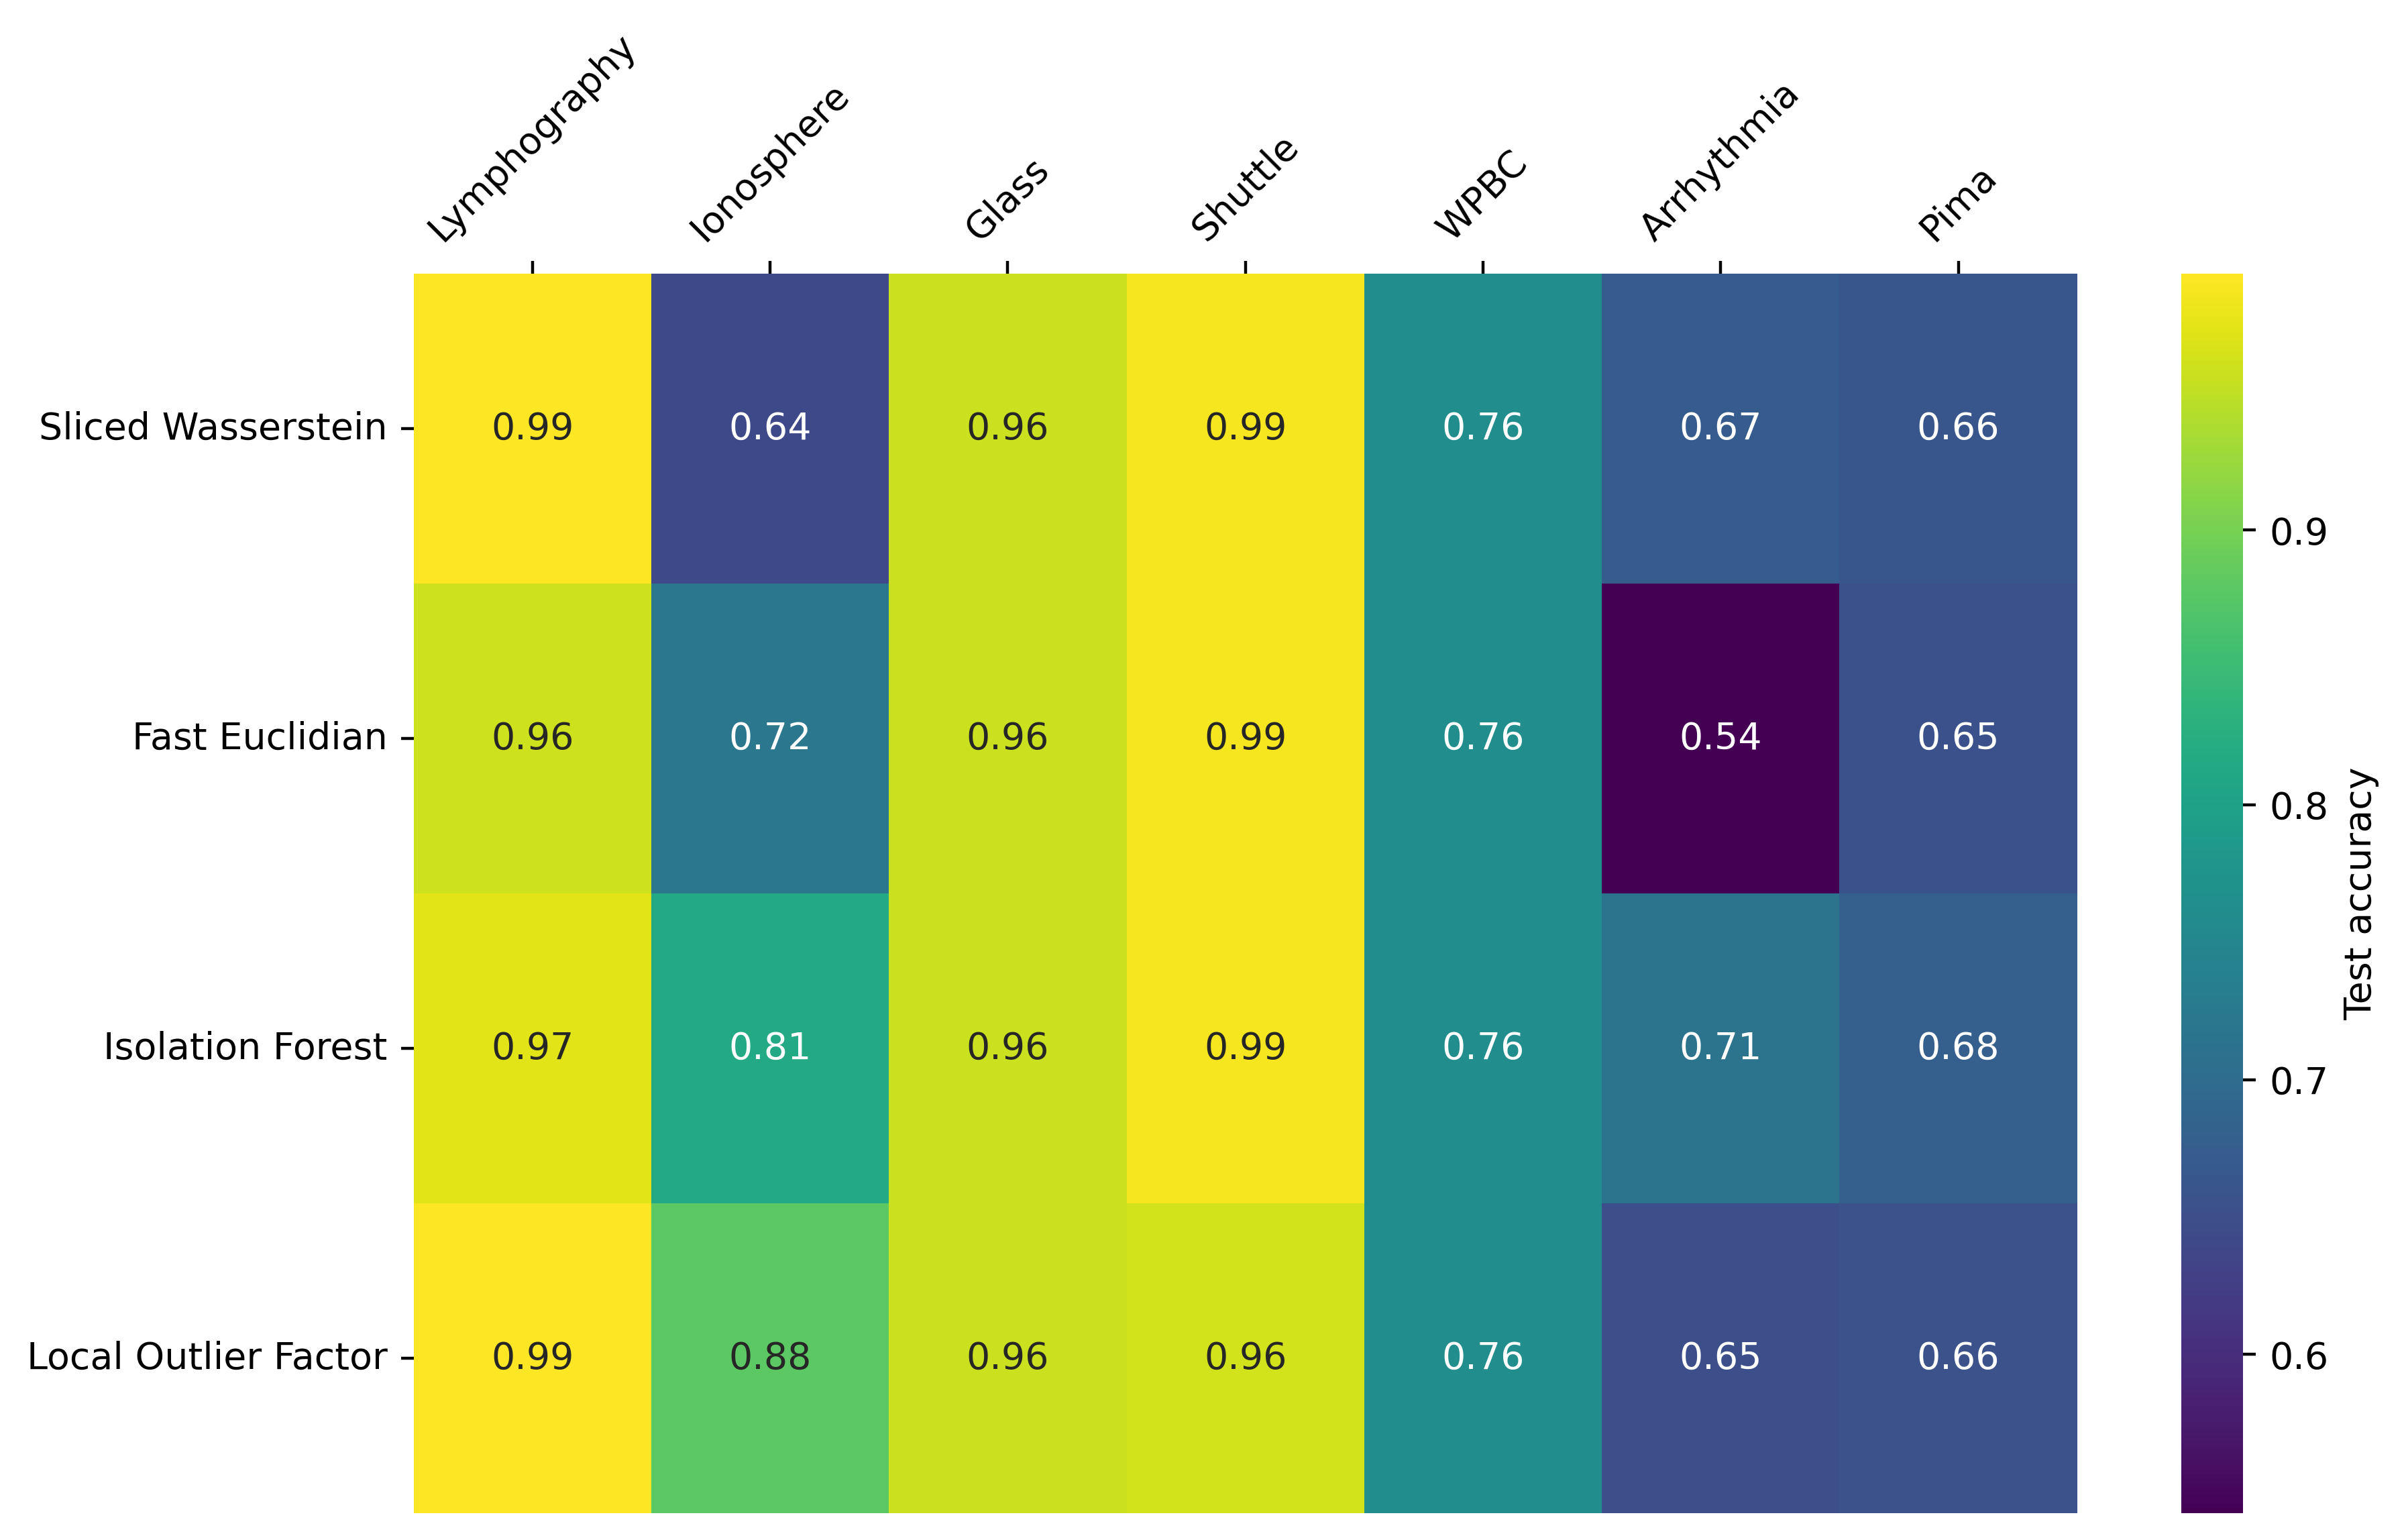

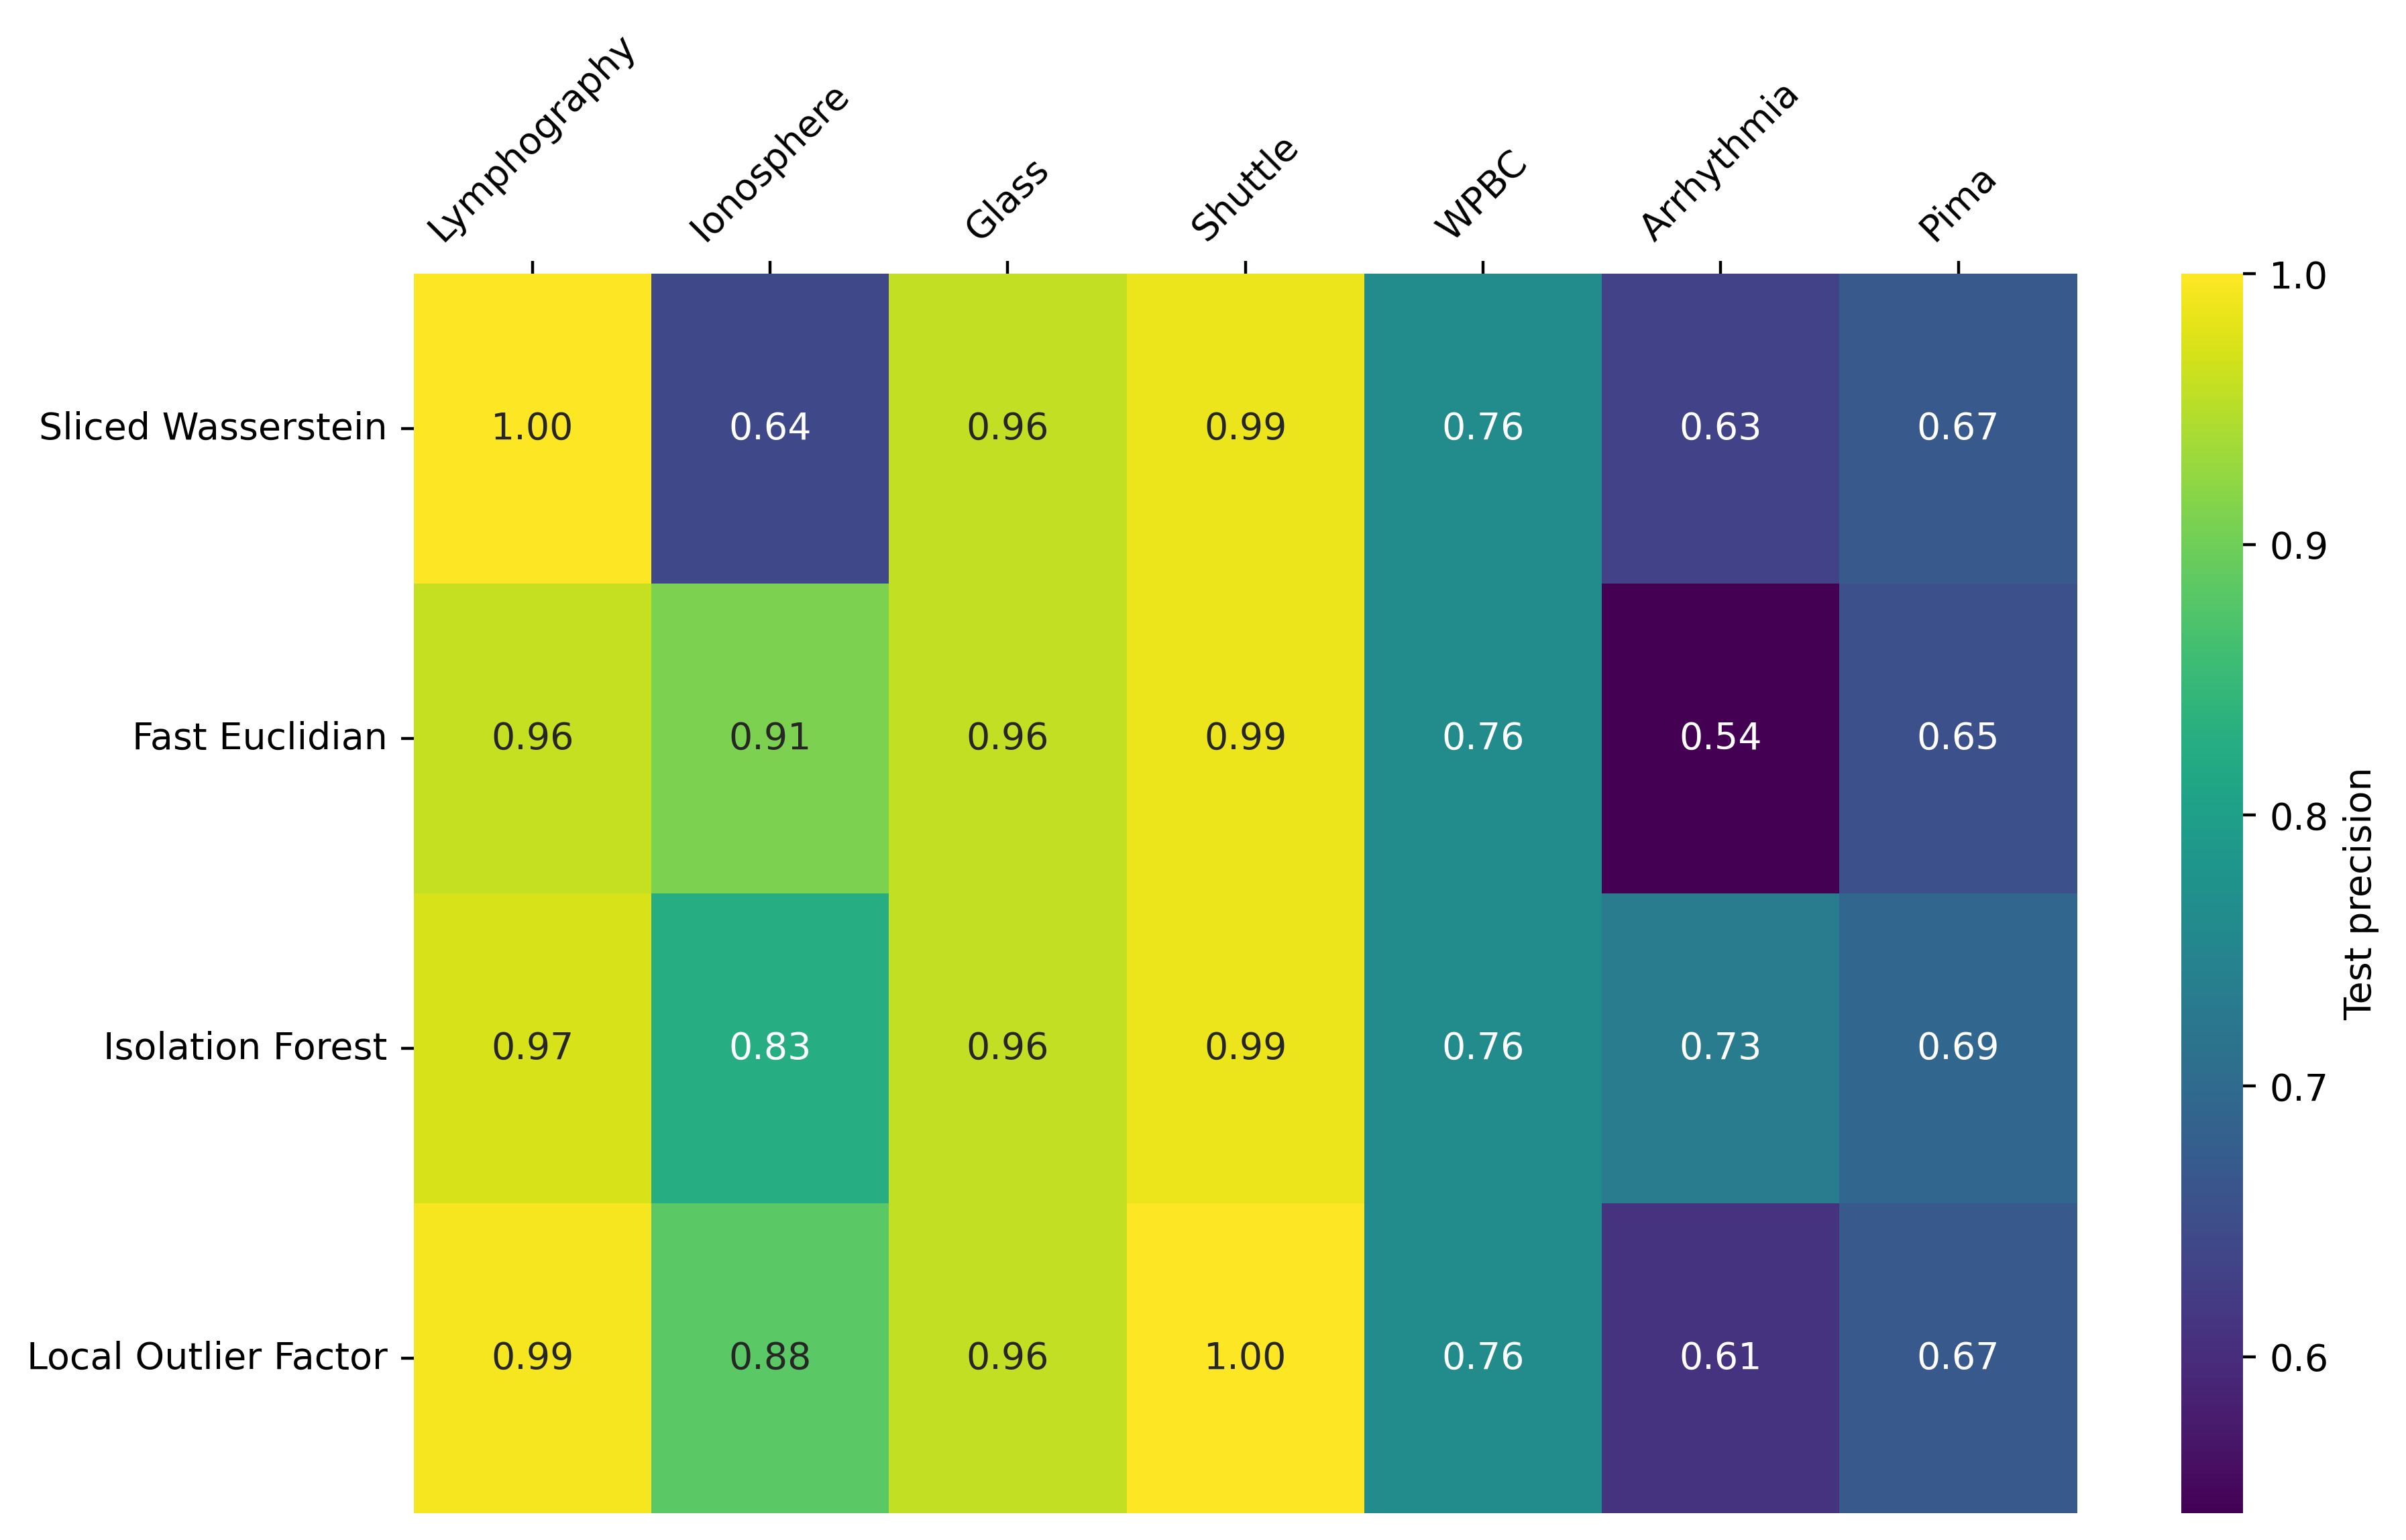

In [18]:
data = data_accuracy
# Normalize each column by its range


plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("viridis", as_cmap=True)
heatmap = sns.heatmap(data.astype(float), cmap=cmap, annot=True, fmt=".2f",cbar_kws={'label': 'Test accuracy'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
plt.savefig('grid_search_accuracy.pdf', bbox_inches='tight')
plt.show()

data = data_precision


plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("viridis", as_cmap=True)
heatmap = sns.heatmap(data.astype(float), cmap=cmap, annot=True, fmt=".2f",cbar_kws={'label': 'Test precision'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
plt.savefig('grid_search_precision.pdf', bbox_inches='tight', dpi=400)
plt.show()
